In [29]:
#plotting function
%matplotlib notebook

In [30]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os

#spec = 2048

#M = 9999 # number of signals

#filein = "/local/2048_Angles_First.h5"

filein = "/mnt/nndataset/experiment1/run1x1/CNN_dataset.hdf5"

with h5py.File(filein, "r") as f:
    folders = f.keys()
    data = f.get('signals/rx_signals')
    
    #print(data.keys())
    #print(data['labels/signals'])
#     items = list(f.items())
#     print('Items in directory:', items)
#     a1 = f.get('signals')
#     a1_items = list(a1.items())
#     print('Signal items:', a1_items)
    
    
    ######
    signal_data = data[0]
    gen_sigs = np.array(signal_data)
    #print(data.keys())
    
    print(signal_data.shape)
    
    bandwidth = np.array(f.get('labels/bandwidth'))
    centerf = np.array(f.get('labels/center_freq'))
    
    #print(np.max(SNR)) 
    SNR = np.array(f.get('labels/SNR')) # standard deviation np.std deviation (?) or divide by largest number np.max(SNR)
    SNR_sf = np.max(SNR)
    print(SNR_sf)
    SNR = SNR/SNR_sf
   # print(np.max(SNR)) 
    
    
    
    #SNR = SNR/(np.std(SNR))  
    
    #data = np.array(S.get('rx_signals'))
    #dataset = data[0,0,:,:] #Sets the last two dimensions of the 4 dimensional array as the main 
                            #dataset
   

    #print(L.keys())
    #print(dataset.shape)
    #bandwidth = np.array(L.get('bandwidth'))
    #centers = np.array(L.get('center_freq')) #TODO: include frequency in name
    #SNR = np.array(L.get('SNR'))
    

(29951, 2048)
40.19734009146633


In [31]:
dataset_fft = abs(np.fft.fftshift(np.fft.fft(gen_sigs), (1,))) #Pass this into NN.
#plt.plot(abs(dataset_fft[20]))
#plt.show()
#dataset_fft = abs(gen_sigs) #Pass this into NN.

# 2 Dimensional Array


# # Creates a list
# inputdata = np.array([dataset_fft, gen_sigs])
# np.shape(inputdata)
# inputdata = np.swapaxes(inputdata, 0, 1)
# np.shape(inputdata)
# inputdata = np.swapaxes(inputdata, 2, 1)

In [32]:
import os
num_threads = 24
os.environ["OMP_NUM_THREADS"] = "24"
os.environ["TF_NUM_INTRAOP_THREADS"] = "24"
os.environ["TF_NUM_INTEROP_THREADS"] = "24"

import tensorflow as tf

#config = tf.ConfigProto(intra_op_parallelism_threads=24,
#                        inter_op_parallelism_threads=2,
#                        allow_soft_placement=True,
#                        device_count = {'CPU': 24})
#session = tf.Session(config=config)
tf.config.threading.set_intra_op_parallelism_threads(24)
tf.config.threading.set_inter_op_parallelism_threads(24)
tf.config.set_soft_device_placement(True)

#from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling1D
import sys
import h5py
import random
import datetime

#Casts a list indexing from 0 to 9999 for each labeled dataset
#Bandwidth
#print(len(bandwidth))
# idx_bw = list(range(len(bandwidth)))
# idx_cf = list(range(len(centerf)))
# idx_start = list(range(len(start)))
# idx_stop = list(range(len(stop)))


idx = list(range(len(centerf)))
#Center Frequency
#idx_cf = list(range(len(centers)))
#Signal-to-Noise Ratio
#idx_SNR = list(range(len(SNR)))



#Shuffles indices of bandwidth, center freq, and SNR datasets
# random.shuffle(idx_bw)


# Ramdom seed 3700 is shuffling data correctly (omitted seed (5) due to it not shuffling)
random.Random(3700).shuffle(idx)
# random.Random(3700).shuffle(idx_start)
# random.Random(3700).shuffle(idx_stop)
#random.shuffle(idx_SNR)

#Splitting datasets (8000 assigned to training and 2000 to testing)
# training_indices_bw, testing_indices_bw = np.split(idx_bw, [int(0.8*len(idx_bw))])
training_indices, testing_indices = np.split(idx, [int(0.8*len(idx))])



training_data = []
training_labels = []
testing_data = []
testing_labels = []




for idx in training_indices:
    #iterate through all indices and print
    training_data.append(dataset_fft[idx])
    training_labels.append([bandwidth[idx], SNR[idx], centerf[idx]])
    #print(idx)

    #put bandwidth training_data and training_labels into a numpy array.
training_data = tf.convert_to_tensor(np.array(training_data), dtype=tf.float32)
training_labels = tf.convert_to_tensor(np.array(training_labels), dtype=tf.float32)
#training_labels_bw = tf.reshape(training_labels_bw, training_labels_bw.get_shape()+(1,))
   
for idx in testing_indices:
    testing_data.append(dataset_fft[idx])
    testing_labels.append([bandwidth[idx], SNR[idx], centerf[idx]])



print(np.shape(training_data))
print(np.shape(training_labels))


print(np.max(training_labels))

training_data = np.array(training_data)
training_labels = np.array(training_labels)

testing_data = np.array(testing_data)
testing_labels = np.array(testing_labels)



(23960, 2048)
(23960, 3)
1.0


In [33]:
from tensorflow import keras
#from tensorflow.keras.layers import Conv2D

finput = tf.keras.layers.Input(shape = (2048, 1), name = "finput") #2 dimensions
##Conv1D(number of kernels (try as few as 4 and go up by factors of 2, NoMachine?),
##length of the kernel (per discussion on board, try around 300), relu may not be the best, try other activation functions)
##Conv1D(How many kernels, points that define the kernels, activation....)

flayer1 = Conv1D(filters=64/2, kernel_size = 3, activation="tanh", name = "flayer1")(finput)
flayer1 = MaxPooling1D(2, name = "fPool1")(flayer1)

if True:
    flayer2 = Conv1D(filters=128/2, kernel_size = 3, activation = "tanh", name = "flayer2")(flayer1)
    flayer2 = MaxPooling1D(2, name = "fPool2")(flayer2)

    flayer3 = Conv1D(filters=256/2, kernel_size = 3, activation = "tanh", name = "flayer3")(flayer2)
else:
    flayer3 = Conv1D(filters=256/2, kernel_size = 3, activation = "tanh", name = "flayer3")(flayer1)

flayer3 = MaxPooling1D(2, name = "fPool3")(flayer3)

flayer4 = Conv1D(filters= 512/2, kernel_size = 3, activation = "tanh", name = "flayer4")(flayer3)
flayer4 = MaxPooling1D(2, name = "fPool4")(flayer4)   

flayer5 = Flatten(name = "fFlatten")(flayer4)

flayer6 = Dense(64, activation = "tanh", name = "fDense1")(flayer5)

foutput = Dense(3, activation = "tanh", name = "fDense2")(flayer6)


model = tf.keras.models.Model(inputs = finput, outputs = foutput)
model.summary()

#opt = keras.optimizers.Adam(learning_rate = 0.00000001)

opt = keras.optimizers.Adam(learning_rate = 0.000001)

#Johnathan Wintrode
model.compile(loss='mean_squared_error', optimizer = opt)


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
finput (InputLayer)          [(None, 2048, 1)]         0         
_________________________________________________________________
flayer1 (Conv1D)             (None, 2046, 32)          128       
_________________________________________________________________
fPool1 (MaxPooling1D)        (None, 1023, 32)          0         
_________________________________________________________________
flayer2 (Conv1D)             (None, 1021, 64)          6208      
_________________________________________________________________
fPool2 (MaxPooling1D)        (None, 510, 64)           0         
_________________________________________________________________
flayer3 (Conv1D)             (None, 508, 128)          24704     
_________________________________________________________________
fPool3 (MaxPooling1D)        (None, 254, 128)          0   

In [ ]:
# from tensorflow import keras
# #from tensorflow.keras.layers import Conv2D

# finput = tf.keras.layers.Input(shape = (2048, 1), name = "finput") #2 dimensions
# ##Conv1D(number of kernels (try as few as 4 and go up by factors of 2, NoMachine?),
# ##length of the kernel (per discussion on board, try around 300), relu may not be the best, try other activation functions)
# ##Conv1D(How many kernels, points that define the kernels, activation....)

# flayer1 = Conv1D(filters=64/2, kernel_size = 3, activation="tanh", name = "flayer1")(finput)
# flayer1 = MaxPooling1D(2, name = "fPool1")(flayer1)

# flayer2 = Conv1D(filters=256/2, kernel_size = 3, activation = "tanh", name = "flayer2")(flayer1)
# flayer2 = MaxPooling1D(2, name = "fPool2")(flayer2)

# flayer3 = Conv1D(filters= 512/2, kernel_size = 3, activation = "tanh", name = "flayer3")(flayer2)
# flayer3 = MaxPooling1D(2, name = "fPool3")(flayer3)   

# flayer4 = Flatten(name = "fFlatten")(flayer3)

# flayer5 = Dense(64, activation = "tanh", name = "fDense1")(flayer4)

# foutput = Dense(3, activation = "tanh", name = "fDense2")(flayer5)


# model = tf.keras.models.Model(inputs = finput, outputs = foutput)
# model.summary()

# #opt = keras.optimizers.Adam(learning_rate = 0.00000001)

# opt = keras.optimizers.Adam(learning_rate = 0.000001)

# #Johnathan Wintrode
# model.compile(loss='mean_squared_error', optimizer = opt)


In [7]:
# IF YOUR KERNEL DIES
model = tf.keras.models.load_model(
    "/local/models/marlomodel.h5", custom_objects=None, compile=True, options=None
)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
finput (InputLayer)          [(None, 2048, 1)]         0         
_________________________________________________________________
flayer1 (Conv1D)             (None, 2046, 32)          128       
_________________________________________________________________
fPool1 (MaxPooling1D)        (None, 1023, 32)          0         
_________________________________________________________________
flayer2 (Conv1D)             (None, 1021, 128)         12416     
_________________________________________________________________
fPool2 (MaxPooling1D)        (None, 510, 128)          0         
_________________________________________________________________
flayer3 (Conv1D)             (None, 508, 256)          98560     
_________________________________________________________________
fPool3 (MaxPooling1D)        (None, 254, 256)          0   

In [6]:
#print(training_data_cf)

In [34]:
filepath = "/local/models/marlomodel.h5"
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='max',
    save_best_only=True)
history_cf = model.fit(training_data, training_labels, epochs=1000, validation_data=(testing_data,testing_labels), callbacks = [callback] )

Epoch 1/1000
749/749 [==============================] - 19s 24ms/step - loss: 0.0495 - val_loss: 0.0105
Epoch 2/1000
749/749 [==============================] - 18s 24ms/step - loss: 0.0097 - val_loss: 0.0084
Epoch 3/1000
749/749 [==============================] - 18s 24ms/step - loss: 0.0081 - val_loss: 0.0075
Epoch 4/1000
749/749 [==============================] - 18s 25ms/step - loss: 0.0071 - val_loss: 0.0069
Epoch 5/1000
749/749 [==============================] - 18s 24ms/step - loss: 0.0065 - val_loss: 0.0064
Epoch 6/1000
749/749 [==============================] - 18s 25ms/step - loss: 0.0059 - val_loss: 0.0057
Epoch 7/1000
749/749 [==============================] - 18s 24ms/step - loss: 0.0054 - val_loss: 0.0052
Epoch 8/1000
749/749 [==============================] - 18s 24ms/step - loss: 0.0050 - val_loss: 0.0049
Epoch 9/1000
749/749 [==============================] - 18s 25ms/step - loss: 0.0046 - val_loss: 0.0045
Epoch 10/1000
749/749 [==============================] - 18s 24m

749/749 [==============================] - 18s 24ms/step - loss: 4.0060e-04 - val_loss: 4.2559e-04
Epoch 77/1000
749/749 [==============================] - 18s 25ms/step - loss: 3.8803e-04 - val_loss: 4.1941e-04
Epoch 78/1000
749/749 [==============================] - 18s 24ms/step - loss: 3.7419e-04 - val_loss: 4.3914e-04
Epoch 79/1000
749/749 [==============================] - 18s 24ms/step - loss: 3.7924e-04 - val_loss: 4.0027e-04
Epoch 80/1000
749/749 [==============================] - 18s 24ms/step - loss: 3.7799e-04 - val_loss: 3.9285e-04
Epoch 81/1000
749/749 [==============================] - 18s 24ms/step - loss: 3.7089e-04 - val_loss: 4.0156e-04
Epoch 82/1000
749/749 [==============================] - 18s 24ms/step - loss: 3.6716e-04 - val_loss: 3.9418e-04
Epoch 83/1000
749/749 [==============================] - 18s 24ms/step - loss: 3.6450e-04 - val_loss: 3.8270e-04
Epoch 84/1000
749/749 [==============================] - 18s 24ms/step - loss: 3.6731e-04 - val_loss: 3.7943e-

749/749 [==============================] - 18s 24ms/step - loss: 2.3903e-04 - val_loss: 2.7464e-04
Epoch 149/1000
749/749 [==============================] - 18s 24ms/step - loss: 2.3428e-04 - val_loss: 2.7044e-04
Epoch 150/1000
749/749 [==============================] - 18s 24ms/step - loss: 2.4006e-04 - val_loss: 2.7096e-04
Epoch 151/1000
749/749 [==============================] - 18s 24ms/step - loss: 2.3426e-04 - val_loss: 2.7190e-04
Epoch 152/1000
749/749 [==============================] - 17s 23ms/step - loss: 2.3519e-04 - val_loss: 2.7211e-04
Epoch 153/1000
749/749 [==============================] - 18s 23ms/step - loss: 2.3302e-04 - val_loss: 2.6836e-04
Epoch 154/1000
749/749 [==============================] - 18s 24ms/step - loss: 2.3442e-04 - val_loss: 2.6727e-04
Epoch 155/1000
749/749 [==============================] - 18s 24ms/step - loss: 2.3015e-04 - val_loss: 2.7065e-04
Epoch 156/1000
749/749 [==============================] - 18s 24ms/step - loss: 2.3102e-04 - val_loss: 

Epoch 220/1000
749/749 [==============================] - 18s 23ms/step - loss: 1.9905e-04 - val_loss: 2.4319e-04
Epoch 221/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.9731e-04 - val_loss: 2.4181e-04
Epoch 222/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.9769e-04 - val_loss: 2.3902e-04
Epoch 223/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.9382e-04 - val_loss: 2.4321e-04
Epoch 224/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.9919e-04 - val_loss: 2.5206e-04
Epoch 225/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.9888e-04 - val_loss: 2.4670e-04
Epoch 226/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.9995e-04 - val_loss: 2.4470e-04
Epoch 227/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.9333e-04 - val_loss: 2.4662e-04
Epoch 228/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.9798e-

Epoch 292/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.7724e-04 - val_loss: 2.3204e-04
Epoch 293/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.7626e-04 - val_loss: 2.3177e-04
Epoch 294/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.7890e-04 - val_loss: 2.3656e-04
Epoch 295/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.7695e-04 - val_loss: 2.3467e-04
Epoch 296/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.7568e-04 - val_loss: 2.3089e-04
Epoch 297/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.7581e-04 - val_loss: 2.3810e-04
Epoch 298/1000
749/749 [==============================] - 17s 23ms/step - loss: 1.7508e-04 - val_loss: 2.3130e-04
Epoch 299/1000
749/749 [==============================] - 18s 25ms/step - loss: 1.7763e-04 - val_loss: 2.2828e-04
Epoch 300/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.7482e-

Epoch 364/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.6657e-04 - val_loss: 2.2729e-04
Epoch 365/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.6269e-04 - val_loss: 2.2365e-04
Epoch 366/1000
749/749 [==============================] - 19s 25ms/step - loss: 1.6506e-04 - val_loss: 2.2576e-04
Epoch 367/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.5967e-04 - val_loss: 2.2269e-04
Epoch 368/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.6369e-04 - val_loss: 2.2549e-04
Epoch 369/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.6274e-04 - val_loss: 2.2535e-04
Epoch 370/1000
749/749 [==============================] - 17s 23ms/step - loss: 1.6090e-04 - val_loss: 2.2690e-04
Epoch 371/1000
749/749 [==============================] - 17s 23ms/step - loss: 1.6122e-04 - val_loss: 2.2914e-04
Epoch 372/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.5746e-

Epoch 436/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.4982e-04 - val_loss: 2.2284e-04
Epoch 437/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.4861e-04 - val_loss: 2.2284e-04
Epoch 438/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.5212e-04 - val_loss: 2.2246e-04
Epoch 439/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.4871e-04 - val_loss: 2.2139e-04
Epoch 440/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.5008e-04 - val_loss: 2.2621e-04
Epoch 441/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.4929e-04 - val_loss: 2.2431e-04
Epoch 442/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.4860e-04 - val_loss: 2.2359e-04
Epoch 443/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.5235e-04 - val_loss: 2.3093e-04
Epoch 444/1000
749/749 [==============================] - 17s 23ms/step - loss: 1.5074e-

Epoch 508/1000
749/749 [==============================] - 17s 23ms/step - loss: 1.4226e-04 - val_loss: 2.2221e-04
Epoch 509/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.4127e-04 - val_loss: 2.2559e-04
Epoch 510/1000
749/749 [==============================] - 17s 23ms/step - loss: 1.3880e-04 - val_loss: 2.2150e-04
Epoch 511/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.4020e-04 - val_loss: 2.2263e-04
Epoch 512/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.4149e-04 - val_loss: 2.2235e-04
Epoch 513/1000
749/749 [==============================] - 18s 23ms/step - loss: 1.3821e-04 - val_loss: 2.2662e-04
Epoch 514/1000
749/749 [==============================] - 18s 25ms/step - loss: 1.4146e-04 - val_loss: 2.1950e-04
Epoch 515/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.4175e-04 - val_loss: 2.2262e-04
Epoch 516/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.3776e-

Epoch 580/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.3175e-04 - val_loss: 2.2041e-04
Epoch 581/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.3197e-04 - val_loss: 2.2051e-04
Epoch 582/1000
749/749 [==============================] - 18s 25ms/step - loss: 1.3050e-04 - val_loss: 2.1972e-04
Epoch 583/1000
749/749 [==============================] - 17s 23ms/step - loss: 1.3096e-04 - val_loss: 2.2685e-04
Epoch 584/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.3257e-04 - val_loss: 2.2333e-04
Epoch 585/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.3326e-04 - val_loss: 2.1961e-04
Epoch 586/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.2911e-04 - val_loss: 2.2090e-04
Epoch 587/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.2944e-04 - val_loss: 2.2488e-04
Epoch 588/1000
749/749 [==============================] - 18s 23ms/step - loss: 1.3091e-

Epoch 652/1000
749/749 [==============================] - 17s 23ms/step - loss: 1.2326e-04 - val_loss: 2.2803e-04
Epoch 653/1000
749/749 [==============================] - 17s 23ms/step - loss: 1.2374e-04 - val_loss: 2.2002e-04
Epoch 654/1000
749/749 [==============================] - 17s 23ms/step - loss: 1.2246e-04 - val_loss: 2.2354e-04
Epoch 655/1000
749/749 [==============================] - 17s 23ms/step - loss: 1.2086e-04 - val_loss: 2.2112e-04
Epoch 656/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.2288e-04 - val_loss: 2.2132e-04
Epoch 657/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.2330e-04 - val_loss: 2.2227e-04
Epoch 658/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.2141e-04 - val_loss: 2.2085e-04
Epoch 659/1000
749/749 [==============================] - 17s 23ms/step - loss: 1.2116e-04 - val_loss: 2.2247e-04
Epoch 660/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.2398e-

Epoch 724/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.1584e-04 - val_loss: 2.3018e-04
Epoch 725/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.1640e-04 - val_loss: 2.2208e-04
Epoch 726/1000
749/749 [==============================] - 18s 23ms/step - loss: 1.1555e-04 - val_loss: 2.2259e-04
Epoch 727/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.1725e-04 - val_loss: 2.2698e-04
Epoch 728/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.1872e-04 - val_loss: 2.2439e-04
Epoch 729/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.1542e-04 - val_loss: 2.3316e-04
Epoch 730/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.1582e-04 - val_loss: 2.2389e-04
Epoch 731/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.1431e-04 - val_loss: 2.2354e-04
Epoch 732/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.1432e-

Epoch 796/1000
749/749 [==============================] - 18s 23ms/step - loss: 1.0768e-04 - val_loss: 2.2298e-04
Epoch 797/1000
749/749 [==============================] - 18s 23ms/step - loss: 1.0837e-04 - val_loss: 2.2241e-04
Epoch 798/1000
749/749 [==============================] - 18s 23ms/step - loss: 1.0788e-04 - val_loss: 2.2430e-04
Epoch 799/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.0840e-04 - val_loss: 2.2416e-04
Epoch 800/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.0814e-04 - val_loss: 2.2556e-04
Epoch 801/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.0838e-04 - val_loss: 2.2291e-04
Epoch 802/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.0806e-04 - val_loss: 2.2429e-04
Epoch 803/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.0984e-04 - val_loss: 2.2345e-04
Epoch 804/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.0770e-

Epoch 868/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.0223e-04 - val_loss: 2.2660e-04
Epoch 869/1000
749/749 [==============================] - 17s 23ms/step - loss: 1.0174e-04 - val_loss: 2.2361e-04
Epoch 870/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.0401e-04 - val_loss: 2.2546e-04
Epoch 871/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.0047e-04 - val_loss: 2.2536e-04
Epoch 872/1000
749/749 [==============================] - 18s 23ms/step - loss: 1.0035e-04 - val_loss: 2.3209e-04
Epoch 873/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.0086e-04 - val_loss: 2.2802e-04
Epoch 874/1000
749/749 [==============================] - 18s 23ms/step - loss: 9.9890e-05 - val_loss: 2.3017e-04
Epoch 875/1000
749/749 [==============================] - 17s 23ms/step - loss: 1.0272e-04 - val_loss: 2.2781e-04
Epoch 876/1000
749/749 [==============================] - 18s 24ms/step - loss: 1.0071e-

Epoch 940/1000
749/749 [==============================] - 18s 24ms/step - loss: 9.6273e-05 - val_loss: 2.2611e-04
Epoch 941/1000
749/749 [==============================] - 18s 23ms/step - loss: 9.6724e-05 - val_loss: 2.2769e-04
Epoch 942/1000
749/749 [==============================] - 18s 24ms/step - loss: 9.6547e-05 - val_loss: 2.2798e-04
Epoch 943/1000
749/749 [==============================] - 18s 24ms/step - loss: 9.6706e-05 - val_loss: 2.2778e-04
Epoch 944/1000
749/749 [==============================] - 17s 23ms/step - loss: 9.6678e-05 - val_loss: 2.2771e-04
Epoch 945/1000
749/749 [==============================] - 18s 24ms/step - loss: 9.6758e-05 - val_loss: 2.2759e-04
Epoch 946/1000
749/749 [==============================] - 18s 24ms/step - loss: 9.6467e-05 - val_loss: 2.3254e-04
Epoch 947/1000
749/749 [==============================] - 18s 24ms/step - loss: 9.5992e-05 - val_loss: 2.2710e-04
Epoch 948/1000
749/749 [==============================] - 18s 24ms/step - loss: 9.5795e-

In [54]:
loss = model.evaluate(testing_data, batch_size=128)
print("test loss, test acc:", loss)
print(loss)
print(history_cf.history)

#mean square
loss = history_cf.history['loss']
val_loss = history_cf.history['val_loss']
#epochs = range(1,9)


#Root mean square
sqrt_loss = np.sqrt(loss)
sqrt_val_loss = np.sqrt(val_loss)

plt.figure(12)

plt.loglog(sqrt_loss, 'r', label='Training Loss')
plt.loglog(sqrt_val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

47/47 [==============================] - 0s 622us/step - loss: 0.0000e+00
test loss, test acc: 0.0
0.0
{'loss': [0.022796645760536194, 0.009100502356886864, 0.007779720239341259, 0.007000322919338942, 0.006335786078125238, 0.0057799555361270905, 0.005297800526022911, 0.0048956782557070255, 0.004509112797677517, 0.004146934952586889, 0.0037912381812930107, 0.003444189205765724, 0.0030980969313532114, 0.0027788192965090275, 0.002477070316672325, 0.0022151386365294456, 0.0019890591502189636, 0.0018034365493804216, 0.001655341824516654, 0.001540554454550147, 0.001449706731364131, 0.0013768922071903944, 0.0013201771071180701, 0.0012731531169265509, 0.0012293063336983323, 0.0011903116246685386, 0.0011568530462682247, 0.0011270589893683791, 0.0011011544847860932, 0.001075690845027566, 0.0010517939226701856, 0.0010346106719225645, 0.0010097292251884937, 0.0009911219822242856, 0.0009737508953548968, 0.0009558623423799872, 0.0009413733496330678, 0.0009245015680789948, 0.0009079914889298379, 0.00

<IPython.core.display.Javascript object>

In [55]:
plt.figure(11)
plt.loglog(sqrt_loss, 'r', label='Training Loss')
plt.loglog(sqrt_val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

                                 NN Prediction              Actual value
          Bandwidth:        0.5705845355987549                 0.5696556
                SNR:         0.840974748134613        0.8464518391006649
   Center Frequency:       0.04897048696875572                  0.049517


<IPython.core.display.Javascript object>


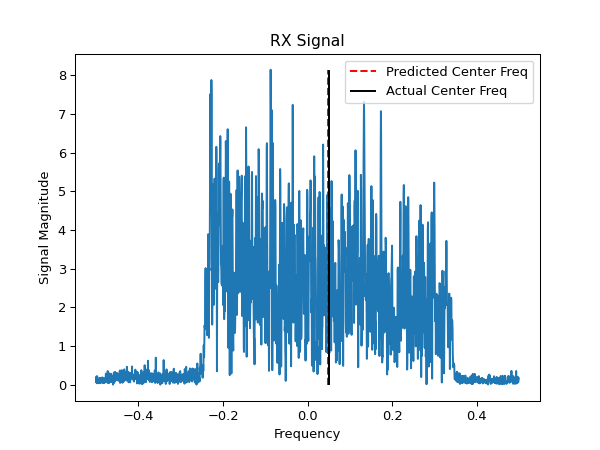

In [68]:
#Random integer input for checking random indices.
import numpy as np

random_index = random.randint(0,len(testing_labels)-1)


predict_cf = model.predict(testing_data)


predict_list = predict_cf[random_index].tolist()
testing_list = testing_labels[random_index].tolist()

#Table of NN Prediction vs the Actual Value
table_data = [
    ['', 'NN Prediction', 'Actual value'],
    ['Bandwidth:', predict_list[0], testing_list[0]],
    ['SNR:', predict_list[1], testing_list[1]],
    ['Center Frequency:', predict_list[2], testing_list[2]],
]

for row in table_data:
    print("{: >20} {: >25} {:>25}".format(*row))

    
    
# Plot of testing data with an overlay of the predicted center frequency vs the actual center frequency.
# NOTE: Orange plot is from the untransformed time data from the beginning of the network and the Blue plot is the 
# fourier transformed frequency data.

plt.figure(1)
num_frequencies = signal_data.shape[1]
start_frequency = -0.5
stop_frequency = (num_frequencies // 2 - 1) / num_frequencies
plt.plot(np.linspace(start_frequency, stop_frequency, num_frequencies),
         abs(testing_data[random_index]))

plt.vlines((predict_list[2]), 0, np.max(testing_data[random_index]), colors = "r", linestyles = "dashed", label = 'Predicted Center Freq')
plt.vlines((testing_list[2]), 0, np.max(testing_data[random_index]), colors = "k", linestyles = "solid", label = 'Actual Center Freq')
plt.legend()
plt.title('RX Signal')
plt.ylabel('Signal Magnitude')
plt.xlabel('Frequency')

plt.show()

#plt.savefig("cf1.svg", format = "svg")

                                 NN Prediction              Actual value
          Bandwidth:        0.8321870565414429                  0.846268
                SNR:       0.24124214053153992       0.21555406439200878
   Center Frequency:      0.014612001366913319                 0.0209648


<IPython.core.display.Javascript object>


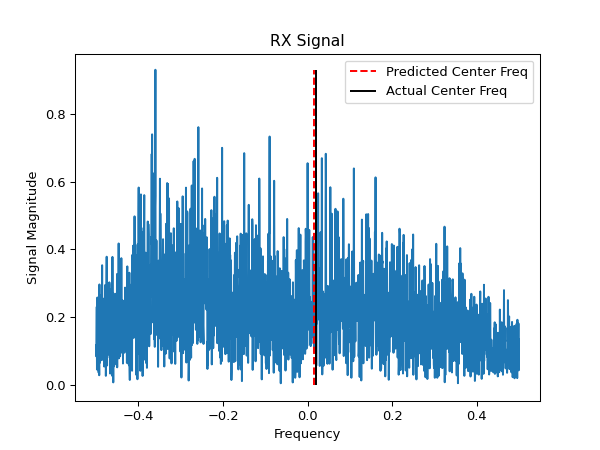

In [52]:
#Random integer input for checking random indices.
import numpy as np

random_index = random.randint(0,len(testing_labels)-1)


predict_cf = model.predict(testing_data)


predict_list = predict_cf[random_index].tolist()
testing_list = testing_labels[random_index].tolist()

#Table of NN Prediction vs the Actual Value
table_data = [
    ['', 'NN Prediction', 'Actual value'],
    ['Bandwidth:', predict_list[0], testing_list[0]],
    ['SNR:', predict_list[1], testing_list[1]],
    ['Center Frequency:', predict_list[2], testing_list[2]],
]

for row in table_data:
    print("{: >20} {: >25} {:>25}".format(*row))

    
    
# Plot of testing data with an overlay of the predicted center frequency vs the actual center frequency.
# NOTE: Orange plot is from the untransformed time data from the beginning of the network and the Blue plot is the 
# fourier transformed frequency data.

plt.figure(2)
num_frequencies = signal_data.shape[1]
start_frequency = -0.5
stop_frequency = (num_frequencies // 2 - 1) / num_frequencies
plt.plot(np.linspace(start_frequency, stop_frequency, num_frequencies),
         abs(testing_data[random_index]))

plt.vlines((predict_list[2]), 0, np.max(testing_data[random_index]), colors = "r", linestyles = "dashed", label = 'Predicted Center Freq')
plt.vlines((testing_list[2]), 0, np.max(testing_data[random_index]), colors = "k", linestyles = "solid", label = 'Actual Center Freq')
plt.legend()
plt.title('RX Signal')
plt.ylabel('Signal Magnitude')
plt.xlabel('Frequency')

plt.show()

#plt.savefig("cf2.svg", format = "svg")

In [38]:
#Random integer input for checking random indices.
import numpy as np

random_index = random.randint(0,len(testing_labels)-1)


predict_cf = model.predict(testing_data)


predict_list = predict_cf[random_index].tolist()
testing_list = testing_labels[random_index].tolist()

#Table of NN Prediction vs the Actual Value
table_data = [
    ['', 'NN Prediction', 'Actual value'],
    ['Bandwidth:', predict_list[0], testing_list[0]],
    ['SNR:', predict_list[1], testing_list[1]],
    ['Center Frequency:', predict_list[2], testing_list[2]],
]

for row in table_data:
    print("{: >20} {: >25} {:>25}".format(*row))

    
    
# Plot of testing data with an overlay of the predicted center frequency vs the actual center frequency.
# NOTE: Orange plot is from the untransformed time data from the beginning of the network and the Blue plot is the 
# fourier transformed frequency data.

plt.figure(3)
num_frequencies = signal_data.shape[1]
start_frequency = -0.5
stop_frequency = (num_frequencies // 2 - 1) / num_frequencies
plt.plot(np.linspace(start_frequency, stop_frequency, num_frequencies),
         abs(testing_data[random_index]))

plt.vlines((predict_list[2]), 0, np.max(testing_data[random_index]), colors = "r", linestyles = "dashed", label = 'Predicted Center Freq')
plt.vlines((testing_list[2]), 0, np.max(testing_data[random_index]), colors = "k", linestyles = "solid", label = 'Actual Center Freq')
plt.legend()
plt.title('RX Signal')
plt.ylabel('Signal Magnitude')
plt.xlabel('Frequency')

plt.show()

#plt.savefig("cf3.svg", format = "svg")

                                 NN Prediction              Actual value
          Bandwidth:         0.222614586353302                 0.2281514
                SNR:        0.8157480359077454        0.8158440942997145
   Center Frequency:      -0.09887998551130295                -0.1011402


<IPython.core.display.Javascript object>

                                 NN Prediction              Actual value
          Bandwidth:       0.14475831389427185                 0.1735398
                SNR:        0.2522578239440918        0.2346165511106793
   Center Frequency:        0.0893552228808403                 0.0709274


<IPython.core.display.Javascript object>


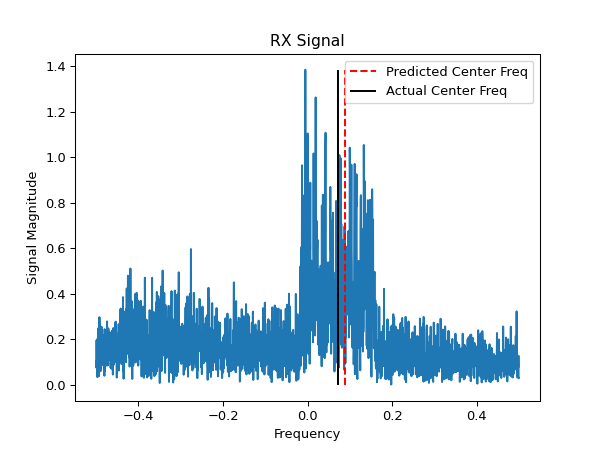

In [50]:
#Random integer input for checking random indices.
import numpy as np

random_index = random.randint(0,len(testing_labels)-1)


predict_cf = model.predict(testing_data)


predict_list = predict_cf[random_index].tolist()
testing_list = testing_labels[random_index].tolist()

#Table of NN Prediction vs the Actual Value
table_data = [
    ['', 'NN Prediction', 'Actual value'],
    ['Bandwidth:', predict_list[0], testing_list[0]],
    ['SNR:', predict_list[1], testing_list[1]],
    ['Center Frequency:', predict_list[2], testing_list[2]],
]

for row in table_data:
    print("{: >20} {: >25} {:>25}".format(*row))

    
    
# Plot of testing data with an overlay of the predicted center frequency vs the actual center frequency.
# NOTE: Orange plot is from the untransformed time data from the beginning of the network and the Blue plot is the 
# fourier transformed frequency data.

plt.figure(4)
num_frequencies = signal_data.shape[1]
start_frequency = -0.5
stop_frequency = (num_frequencies // 2 - 1) / num_frequencies
plt.plot(np.linspace(start_frequency, stop_frequency, num_frequencies),
         abs(testing_data[random_index]))

plt.vlines((predict_list[2]), 0, np.max(testing_data[random_index]), colors = "r", linestyles = "dashed", label = 'Predicted Center Freq')
plt.vlines((testing_list[2]), 0, np.max(testing_data[random_index]), colors = "k", linestyles = "solid", label = 'Actual Center Freq')
plt.legend()
plt.title('RX Signal')
plt.ylabel('Signal Magnitude')
plt.xlabel('Frequency')

plt.show()

#plt.savefig("cf4.svg", format = "svg")

                                 NN Prediction              Actual value
          Bandwidth:        0.3842248320579529                  0.390313
                SNR:       0.23584720492362976       0.21797774482752752
   Center Frequency:       0.07072267681360245                 0.0690396


<IPython.core.display.Javascript object>


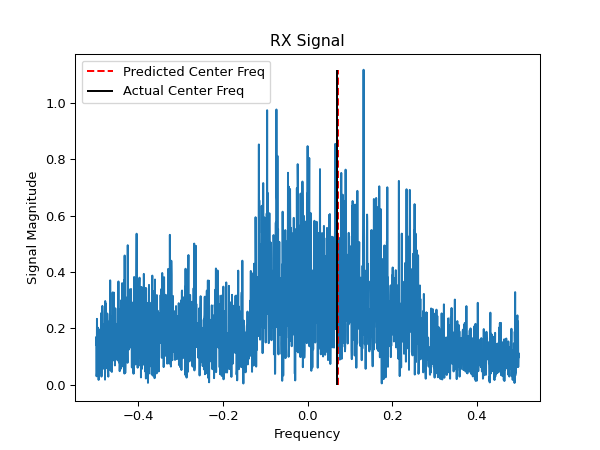

In [40]:
#Random integer input for checking random indices.
import numpy as np

random_index = random.randint(0,len(testing_labels)-1)


predict_cf = model.predict(testing_data)


predict_list = predict_cf[random_index].tolist()
testing_list = testing_labels[random_index].tolist()

#Table of NN Prediction vs the Actual Value
table_data = [
    ['', 'NN Prediction', 'Actual value'],
    ['Bandwidth:', predict_list[0], testing_list[0]],
    ['SNR:', predict_list[1], testing_list[1]],
    ['Center Frequency:', predict_list[2], testing_list[2]],
]

for row in table_data:
    print("{: >20} {: >25} {:>25}".format(*row))

    
    
# Plot of testing data with an overlay of the predicted center frequency vs the actual center frequency.
# NOTE: Orange plot is from the untransformed time data from the beginning of the network and the Blue plot is the 
# fourier transformed frequency data.

plt.figure(5)
num_frequencies = signal_data.shape[1]
start_frequency = -0.5
stop_frequency = (num_frequencies // 2 - 1) / num_frequencies
plt.plot(np.linspace(start_frequency, stop_frequency, num_frequencies),
         abs(testing_data[random_index]))

plt.vlines((predict_list[2]), 0, np.max(testing_data[random_index]), colors = "r", linestyles = "dashed", label = 'Predicted Center Freq')
plt.vlines((testing_list[2]), 0, np.max(testing_data[random_index]), colors = "k", linestyles = "solid", label = 'Actual Center Freq')
plt.legend()
plt.title('RX Signal')
plt.ylabel('Signal Magnitude')
plt.xlabel('Frequency')

plt.show()

#plt.savefig("cf5.svg", format = "svg")

                                 NN Prediction              Actual value
          Bandwidth:        0.2114790976047516                 0.2138864
                SNR:        0.8454641103744507        0.8532945367910113
   Center Frequency:      -0.08418990671634674                -0.0807196


<IPython.core.display.Javascript object>


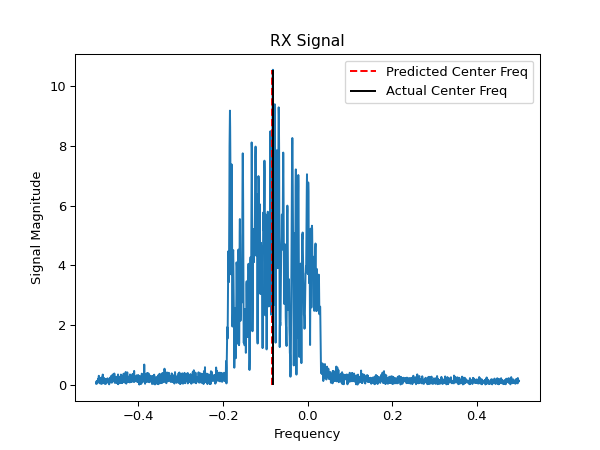

In [41]:
#Random integer input for checking random indices.
import numpy as np

random_index = random.randint(0,len(testing_labels)-1)


predict_cf = model.predict(testing_data)


predict_list = predict_cf[random_index].tolist()
testing_list = testing_labels[random_index].tolist()

#Table of NN Prediction vs the Actual Value
table_data = [
    ['', 'NN Prediction', 'Actual value'],
    ['Bandwidth:', predict_list[0], testing_list[0]],
    ['SNR:', predict_list[1], testing_list[1]],
    ['Center Frequency:', predict_list[2], testing_list[2]],
]

for row in table_data:
    print("{: >20} {: >25} {:>25}".format(*row))

    
    
# Plot of testing data with an overlay of the predicted center frequency vs the actual center frequency.
# NOTE: Orange plot is from the untransformed time data from the beginning of the network and the Blue plot is the 
# fourier transformed frequency data.

plt.figure(6)
num_frequencies = signal_data.shape[1]
start_frequency = -0.5
stop_frequency = (num_frequencies // 2 - 1) / num_frequencies
plt.plot(np.linspace(start_frequency, stop_frequency, num_frequencies),
         abs(testing_data[random_index]))

plt.vlines((predict_list[2]), 0, np.max(testing_data[random_index]), colors = "r", linestyles = "dashed", label = 'Predicted Center Freq')
plt.vlines((testing_list[2]), 0, np.max(testing_data[random_index]), colors = "k", linestyles = "solid", label = 'Actual Center Freq')
plt.legend()
plt.title('RX Signal')
plt.ylabel('Signal Magnitude')
plt.xlabel('Frequency')

plt.show()

#plt.savefig("cf6.svg", format = "svg")

                                 NN Prediction              Actual value
          Bandwidth:        0.3489578068256378                 0.3391726
                SNR:        0.9446513652801514        0.9324868216690864
   Center Frequency:      -0.10844801366329193                -0.1129578


<IPython.core.display.Javascript object>


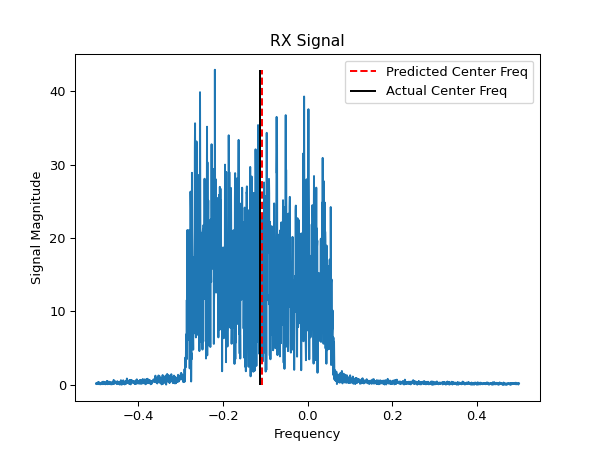

In [49]:
#Random integer input for checking random indices.
import numpy as np

random_index = random.randint(0,len(testing_labels)-1)


predict_cf = model.predict(testing_data)


predict_list = predict_cf[random_index].tolist()
testing_list = testing_labels[random_index].tolist()

#Table of NN Prediction vs the Actual Value
table_data = [
    ['', 'NN Prediction', 'Actual value'],
    ['Bandwidth:', predict_list[0], testing_list[0]],
    ['SNR:', predict_list[1], testing_list[1]],
    ['Center Frequency:', predict_list[2], testing_list[2]],
]

for row in table_data:
    print("{: >20} {: >25} {:>25}".format(*row))

    
    
# Plot of testing data with an overlay of the predicted center frequency vs the actual center frequency.
# NOTE: Orange plot is from the untransformed time data from the beginning of the network and the Blue plot is the 
# fourier transformed frequency data.

plt.figure(7)
num_frequencies = signal_data.shape[1]
start_frequency = -0.5
stop_frequency = (num_frequencies // 2 - 1) / num_frequencies
plt.plot(np.linspace(start_frequency, stop_frequency, num_frequencies),
         abs(testing_data[random_index]))

plt.vlines((predict_list[2]), 0, np.max(testing_data[random_index]), colors = "r", linestyles = "dashed", label = 'Predicted Center Freq')
plt.vlines((testing_list[2]), 0, np.max(testing_data[random_index]), colors = "k", linestyles = "solid", label = 'Actual Center Freq')
plt.legend()
plt.title('RX Signal')
plt.ylabel('Signal Magnitude')
plt.xlabel('Frequency')

plt.show()

#plt.savefig("cf7.svg", format = "svg")

In [47]:
#Random integer input for checking random indices.
import numpy as np

random_index = random.randint(0,len(testing_labels)-1)


predict_cf = model.predict(testing_data)


predict_list = predict_cf[random_index].tolist()
testing_list = testing_labels[random_index].tolist()

#Table of NN Prediction vs the Actual Value
table_data = [
    ['', 'NN Prediction', 'Actual value'],
    ['Bandwidth:', predict_list[0], testing_list[0]],
    ['SNR:', predict_list[1], testing_list[1]],
    ['Center Frequency:', predict_list[2], testing_list[2]],
]

for row in table_data:
    print("{: >20} {: >25} {:>25}".format(*row))

    
    
# Plot of testing data with an overlay of the predicted center frequency vs the actual center frequency.
# NOTE: Orange plot is from the untransformed time data from the beginning of the network and the Blue plot is the 
# fourier transformed frequency data.

plt.figure(8)
num_frequencies = signal_data.shape[1]
start_frequency = -0.5
stop_frequency = (num_frequencies // 2 - 1) / num_frequencies
plt.plot(np.linspace(start_frequency, stop_frequency, num_frequencies),
         abs(testing_data[random_index]))

plt.vlines((predict_list[2]), 0, np.max(testing_data[random_index]), colors = "r", linestyles = "dashed", label = 'Predicted Center Freq')
plt.vlines((testing_list[2]), 0, np.max(testing_data[random_index]), colors = "k", linestyles = "solid", label = 'Actual Center Freq')
plt.legend()
plt.title('RX Signal')
plt.ylabel('Signal Magnitude')
plt.xlabel('Frequency')

plt.show()

#plt.savefig("cf8.svg", format = "svg")

                                 NN Prediction              Actual value
          Bandwidth:        0.1440473049879074                 0.2092484
                SNR:        0.2705950438976288        0.2592708136178818
   Center Frequency:       0.10725583136081696                  0.112554


<IPython.core.display.Javascript object>

                                 NN Prediction              Actual value
          Bandwidth:        0.4661308228969574                 0.4796412
                SNR:        0.8218024969100952        0.8349767861947562
   Center Frequency:     -0.010911856777966022                -0.0150084


<IPython.core.display.Javascript object>


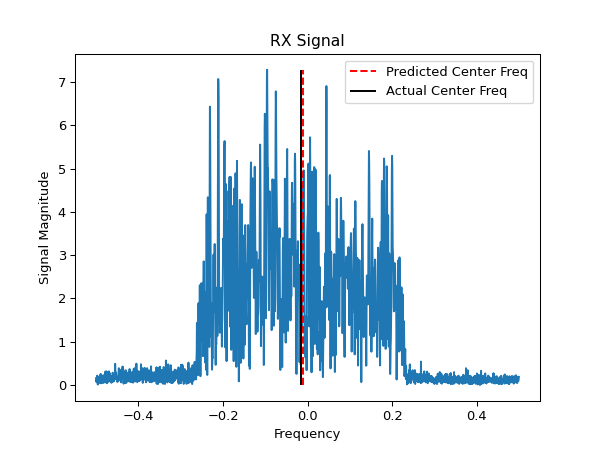

In [44]:
#Random integer input for checking random indices.
import numpy as np

random_index = random.randint(0,len(testing_labels)-1)


predict_cf = model.predict(testing_data)


predict_list = predict_cf[random_index].tolist()
testing_list = testing_labels[random_index].tolist()

#Table of NN Prediction vs the Actual Value
table_data = [
    ['', 'NN Prediction', 'Actual value'],
    ['Bandwidth:', predict_list[0], testing_list[0]],
    ['SNR:', predict_list[1], testing_list[1]],
    ['Center Frequency:', predict_list[2], testing_list[2]],
]

for row in table_data:
    print("{: >20} {: >25} {:>25}".format(*row))

    
    
# Plot of testing data with an overlay of the predicted center frequency vs the actual center frequency.
# NOTE: Orange plot is from the untransformed time data from the beginning of the network and the Blue plot is the 
# fourier transformed frequency data.

plt.figure(9)
num_frequencies = signal_data.shape[1]
start_frequency = -0.5
stop_frequency = (num_frequencies // 2 - 1) / num_frequencies
plt.plot(np.linspace(start_frequency, stop_frequency, num_frequencies),
         abs(testing_data[random_index]))

plt.vlines((predict_list[2]), 0, np.max(testing_data[random_index]), colors = "r", linestyles = "dashed", label = 'Predicted Center Freq')
plt.vlines((testing_list[2]), 0, np.max(testing_data[random_index]), colors = "k", linestyles = "solid", label = 'Actual Center Freq')
plt.legend()
plt.title('RX Signal')
plt.ylabel('Signal Magnitude')
plt.xlabel('Frequency')

plt.show()

#plt.savefig("cf9.svg", format = "svg")

In [45]:
#Random integer input for checking random indices.
import numpy as np

random_index = random.randint(0,len(testing_labels)-1)


predict_cf = model.predict(testing_data)


predict_list = predict_cf[random_index].tolist()
testing_list = testing_labels[random_index].tolist()

#Table of NN Prediction vs the Actual Value
table_data = [
    ['', 'NN Prediction', 'Actual value'],
    ['Bandwidth:', predict_list[0], testing_list[0]],
    ['SNR:', predict_list[1], testing_list[1]],
    ['Center Frequency:', predict_list[2], testing_list[2]],
]

for row in table_data:
    print("{: >20} {: >25} {:>25}".format(*row))

    
    
# Plot of testing data with an overlay of the predicted center frequency vs the actual center frequency.
# NOTE: Orange plot is from the untransformed time data from the beginning of the network and the Blue plot is the 
# fourier transformed frequency data.

plt.figure(10)
num_frequencies = signal_data.shape[1]
start_frequency = -0.5
stop_frequency = (num_frequencies // 2 - 1) / num_frequencies
plt.plot(np.linspace(start_frequency, stop_frequency, num_frequencies),
         abs(testing_data[random_index]))

plt.vlines((predict_list[2]), 0, np.max(testing_data[random_index]), colors = "r", linestyles = "dashed", label = 'Predicted Center Freq')
plt.vlines((testing_list[2]), 0, np.max(testing_data[random_index]), colors = "k", linestyles = "solid", label = 'Actual Center Freq')
plt.legend()
plt.title('RX Signal')
plt.ylabel('Signal Magnitude')
plt.xlabel('Frequency')

plt.show()

#plt.savefig("cf10.svg", format = "svg")

                                 NN Prediction              Actual value
          Bandwidth:        0.6949167251586914                 0.6880702
                SNR:        0.2742602527141571       0.27108594053786644
   Center Frequency:     -0.002891212236136198                -0.0001002


<IPython.core.display.Javascript object>

In [23]:
#Random integer input for checking random indices.

random_index = random.randint(0,len(testing_labels)-1)

print("Index value:", random_index)

predict_cf = model.predict(testing_data)

print("Inferred value:", predict_cf[random_index])
print("Actual value:", testing_labels[random_index])



plt.figure()
num_frequencies = signal_data.shape[1]
start_frequency = -0.5
stop_frequency = (num_frequencies // 2 - 1) / num_frequencies
plt.plot(np.linspace(start_frequency, stop_frequency, num_frequencies),
         abs(dataset_fft[random_index]))
plt.show()


Index value: 723
Inferred value: [ 0.7930518   0.9331132  -0.03425229]
Actual value: [ 0.7956626   0.94982464 -0.0300584 ]


<IPython.core.display.Javascript object>

In [16]:
#Random integer input for checking random indices.

random_index = random.randint(0,len(testing_labels)-1)

print("Index value:", random_index)

predict_cf = model.predict(testing_data)

print("Inferred value:", predict_cf[random_index])
print("Actual value:", testing_labels[random_index])
print(centerf[random_index])

Index value: 2627
Inferred value: [0.61639386 0.2163418  0.06737908]
Actual value: [0.6041006  0.23696989 0.0384532 ]
-0.0406362


In [17]:
#Random integer input for checking random indices.

random_index = random.randint(0,len(testing_labels)-1)

print("Index value:", random_index)

predict_cf = model.predict(testing_data)

print("Inferred value:", predict_cf[random_index])
print("Actual value:", testing_labels[random_index])
print(centerf[random_index])

Index value: 2427
Inferred value: [ 0.11599883  0.26472372 -0.1002478 ]
Actual value: [ 0.1765962   0.26694461 -0.0841622 ]
0.0188362


In [14]:
plt.plot(sqrt_loss, 'r', label='Training Loss')
plt.plot(sqrt_val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
loss_cf = model.evaluate(testing_data_cf, batch_size=128)
print("test loss, test acc:", loss_cf)
print(loss_cf)
print(history_cf.history)

#mean square
loss_cf = history_cf.history['loss']
val_loss_cf = history_cf.history['val_loss']
#epochs = range(1,9)


#Root mean square
sqrt_loss = np.sqrt(loss_cf)
sqrt_val_loss = np.sqrt(val_loss_cf)

In [46]:
plt.figure()
plt.loglog(sqrt_loss, 'r', label='Training Loss')
plt.loglog(sqrt_val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

In [18]:
model.save('freqmodel.h5')